# Project: Identify Customer Segments

In this project, you will apply unsupervised learning techniques to identify segments of the population that form the core customer base for a mail-order sales company in Germany. These segments can then be used to direct marketing campaigns towards audiences that will have the highest expected rate of returns. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

This notebook will help you complete this task by providing a framework within which you will perform your analysis steps. In each step of the project, you will see some text describing the subtask that you will perform, followed by one or more code cells for you to complete your work. **Feel free to add additional code and markdown cells as you go along so that you can explore everything in precise chunks.** The code cells provided in the base template will outline only the major tasks, and will usually not be enough to cover all of the minor tasks that comprise it.

It should be noted that while there will be precise guidelines on how you should handle certain tasks in the project, there will also be places where an exact specification is not provided. **There will be times in the project where you will need to make and justify your own decisions on how to treat the data.** These are places where there may not be only one way to handle the data. In real-life tasks, there may be many valid ways to approach an analysis task. One of the most important things you can do is clearly document your approach so that other scientists can understand the decisions you've made.

At the end of most sections, there will be a Markdown cell labeled **Discussion**. In these cells, you will report your findings for the completed section, as well as document the decisions that you made in your approach to each subtask. **Your project will be evaluated not just on the code used to complete the tasks outlined, but also your communication about your observations and conclusions at each stage.**

In [1]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import ast
import re
import random
import json

from sklearn.preprocessing import Imputer
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

from IPython.display import Markdown as md

# magic word for producing visualizations in notebook
%matplotlib inline

random.seed(2)
np.random.seed(2)

### Step 0: Load the Data

There are four files associated with this project (not including this one):

- `Udacity_AZDIAS_Subset.csv`: Demographics data for the general population of Germany; 891211 persons (rows) x 85 features (columns).
- `Udacity_CUSTOMERS_Subset.csv`: Demographics data for customers of a mail-order company; 191652 persons (rows) x 85 features (columns).
- `Data_Dictionary.md`: Detailed information file about the features in the provided datasets.
- `AZDIAS_Feature_Summary.csv`: Summary of feature attributes for demographics data; 85 features (rows) x 4 columns

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. You will use this information to cluster the general population into groups with similar demographic properties. Then, you will see how the people in the customers dataset fit into those created clusters. The hope here is that certain clusters are over-represented in the customers data, as compared to the general population; those over-represented clusters will be assumed to be part of the core userbase. This information can then be used for further applications, such as targeting for a marketing campaign.

To start off with, load in the demographics data for the general population into a pandas DataFrame, and do the same for the feature attributes summary. Note for all of the `.csv` data files in this project: they're semicolon (`;`) delimited, so you'll need an additional argument in your [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call to read in the data properly. Also, considering the size of the main dataset, it may take some time for it to load completely.

Once the dataset is loaded, it's recommended that you take a little bit of time just browsing the general structure of the dataset and feature summary file. You'll be getting deep into the innards of the cleaning in the first major step of the project, so gaining some general familiarity can help you get your bearings.

In [2]:
# Load in the general demographics data.
azdias = pd.read_csv("Udacity_AZDIAS_Subset.csv", sep=';')

In [3]:
# Load in the feature summary file.
feat_info = pd.read_csv("AZDIAS_Feature_Summary.csv", sep=';')

# Let's also do some basic cleaning.
feat_info.missing_or_unknown.replace(to_replace=r'X', value=r'"X"', regex=True, inplace=True)
feat_info.missing_or_unknown.replace(to_replace=r'\"\"', value=r'', regex=True, inplace=True)

In [4]:
# Check the structure of the data after it's loaded (e.g. print the number of
# rows and columns, print the first few rows).
print(azdias.shape)
print(azdias.head(2))
print(azdias.info())
#print(feat_info.head(2))

(891221, 85)
   AGER_TYP  ALTERSKATEGORIE_GROB  ANREDE_KZ  CJT_GESAMTTYP  \
0        -1                     2          1            2.0   
1        -1                     1          2            5.0   

   FINANZ_MINIMALIST  FINANZ_SPARER  FINANZ_VORSORGER  FINANZ_ANLEGER  \
0                  3              4                 3               5   
1                  1              5                 2               5   

   FINANZ_UNAUFFAELLIGER  FINANZ_HAUSBAUER    ...     PLZ8_ANTG1  PLZ8_ANTG2  \
0                      5                 3    ...            NaN         NaN   
1                      4                 5    ...            2.0         3.0   

   PLZ8_ANTG3  PLZ8_ANTG4  PLZ8_BAUMAX  PLZ8_HHZ  PLZ8_GBZ  ARBEIT  \
0         NaN         NaN          NaN       NaN       NaN     NaN   
1         2.0         1.0          1.0       5.0       4.0     3.0   

   ORTSGR_KLS9  RELAT_AB  
0          NaN       NaN  
1          5.0       4.0  

[2 rows x 85 columns]
<class 'pandas.core.f

Next we create a dictionary to translate feature names to feature descriptions from Data_Dictionary.md. It will be updated as we modify the set of columns. 

In [5]:
with open('Data_Dictionary.md') as file:  
    data_dictionary = file.read() 


In [6]:
# Extract all single line variable names and their translations. 
pattern1 = re.compile('### \d{1}\.\d{1,2}. (.*)\n([^#].*)\n')
result1 = re.findall(pattern1, string=data_dictionary)
feat_dict = {de:en for de, en in result1}

In [7]:
# Extract all FINANZ_XXX and SEMIO_XXX names and their translations. 
pattern2 = re.compile('### \d{1}\.\d{1,2}. (.*?)_.*(?:\n###.*){1,2}\n(\w*).*(?:\n.*){0,13}Dimension translations:((?:\n.*){0,15})\n\n###')
result2 = re.findall(pattern2, string=data_dictionary)

translations = [re.findall(string=result2[i][2], pattern=re.compile('\n- (\w*): (.*)')) for i in range(len(result2))]
feat_list = [{result2[i][0]+'_'+translations[i][j][0]:result2[i][1]+' dimension: '+translations[i][j][1] 
               for j in range(len(translations[i]))} for i in range(len(result2))]

for i in range(len(feat_list)):
    feat_dict.update(feat_list[i])

> **Tip**: Add additional cells to keep everything in reasonably-sized chunks! Keyboard shortcut `esc --> a` (press escape to enter command mode, then press the 'A' key) adds a new cell before the active cell, and `esc --> b` adds a new cell after the active cell. If you need to convert an active cell to a markdown cell, use `esc --> m` and to convert to a code cell, use `esc --> y`. 

## Step 1: Preprocessing

### Step 1.1: Assess Missing Data

The feature summary file contains a summary of properties for each demographics data column. You will use this file to help you make cleaning decisions during this stage of the project. First of all, you should assess the demographics data in terms of missing data. Pay attention to the following points as you perform your analysis, and take notes on what you observe. Make sure that you fill in the **Discussion** cell with your findings and decisions at the end of each step that has one!

#### Step 1.1.1: Convert Missing Value Codes to NaNs
The fourth column of the feature attributes summary (loaded in above as `feat_info`) documents the codes from the data dictionary that indicate missing or unknown data. While the file encodes this as a list (e.g. `[-1,0]`), this will get read in as a string object. You'll need to do a little bit of parsing to make use of it to identify and clean the data. Convert data that matches a 'missing' or 'unknown' value code into a numpy NaN value. You might want to see how much data takes on a 'missing' or 'unknown' code, and how much data is naturally missing, as a point of interest.

**As one more reminder, you are encouraged to add additional cells to break up your analysis into manageable chunks.**

In [8]:
# Identify missing or unknown data values and convert them to NaNs.

In [9]:
# Build replacement dictionaries for each column. 
nan_codes=dict()
for i in range(feat_info.shape[0]):
    codes = ast.literal_eval(feat_info.missing_or_unknown[i])
    nan_codes[feat_info.attribute[i]] = dict()
    for code in codes:
        nan_codes[feat_info.attribute[i]][code] = np.nan

In [10]:
azdias_nan = azdias.replace(to_replace=nan_codes)

In [11]:
# Do a quick check: 'X' values are now gone.
print(azdias_nan.CAMEO_DEUG_2015.value_counts(dropna = False))
print(azdias.CAMEO_DEUG_2015.value_counts(dropna = False))

8      134441
9      108177
6      105874
4      103912
NaN     99352
3       86779
2       83231
7       77933
5       55310
1       36212
Name: CAMEO_DEUG_2015, dtype: int64
8      134441
9      108177
6      105874
4      103912
NaN     98979
3       86779
2       83231
7       77933
5       55310
1       36212
X         373
Name: CAMEO_DEUG_2015, dtype: int64


Next we explore how much of the data is naturally missing as opposed to how much of it is encoded as missing. 

In [12]:
# Count encoded and naturally missing values. 
natural_to_all = []
natural_nans_list = []
all_nans_list = []
for i in range(feat_info.shape[0]):
    all_nans = azdias_nan[feat_info.attribute[i]].isnull().sum()
    natural_nans = azdias[feat_info.attribute[i]].isnull().sum()
    all_nans_list.append(all_nans)
    natural_nans_list.append(natural_nans)
    if all_nans == 0:
        natural_to_all.append(np.nan)
    else:    
        natural_to_all.append(natural_nans * 1.0 / all_nans)
        
missing_counts = pd.DataFrame({'all_nans':all_nans_list, 'natural_nans':natural_nans_list, 
                              'natural_to_all':natural_to_all}, 
                              index=feat_info.attribute).sort_values(by=['natural_to_all'])        

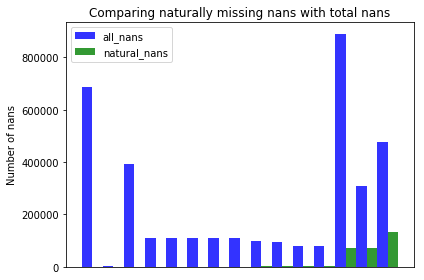

In [13]:
# Plot NaN counts for 15 columns with the smallest fraction of naturally missing values among all missing values. 
fig, ax = plt.subplots()
index = np.arange(15)
bar_width = 0.5
opacity = 0.8
 
rects1 = plt.bar(index, missing_counts['all_nans'][:15], bar_width,
                 alpha=opacity,
                 color='b',
                 label='all_nans')
 
rects2 = plt.bar(index + bar_width, missing_counts['natural_nans'][:15], bar_width,
                 alpha=opacity,
                 color='g',
                 label='natural_nans')

plt.ylabel('Number of nans')
plt.title('Comparing naturally missing nans with total nans')
plt.xticks([], [])
plt.legend()
 
plt.tight_layout()    

#### Step 1.1.2: Assess Missing Data in Each Column

How much missing data is present in each column? There are a few columns that are outliers in terms of the proportion of values that are missing. You will want to use matplotlib's [`hist()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.hist.html) function to visualize the distribution of missing value counts to find these columns. Identify and document these columns. While some of these columns might have justifications for keeping or re-encoding the data, for this project you should just remove them from the dataframe. (Feel free to make remarks about these outlier columns in the discussion, however!)

For the remaining features, are there any patterns in which columns have, or share, missing data?

Text(0.5,0,'Portion of missing values in a column')

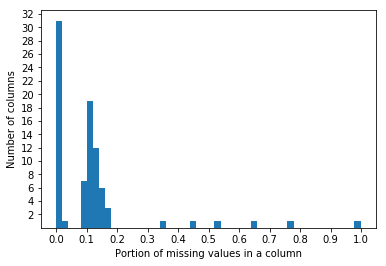

In [14]:
# Perform an assessment of how much missing data there is in each column of the
# dataset.

column_nan = azdias_nan.isnull().sum()
plt.hist(column_nan * 1.0 / azdias_nan.shape[0], bins=50)
plt.yticks(np.arange(2,33,step=2))
plt.xticks(np.arange(0,1.05,step=0.1))
plt.ylabel('Number of columns')
plt.xlabel('Portion of missing values in a column')


In [19]:
# Investigate patterns in the amount of missing data in each column.

In [15]:
# Group columns according to the number of missing values. 
columns_with_same_numNaNs = {n:list(column_nan[column_nan == n].index) for n in column_nan.unique()}
columns_with_same_numNaNs

{0: ['ANREDE_KZ',
  'FINANZ_MINIMALIST',
  'FINANZ_SPARER',
  'FINANZ_VORSORGER',
  'FINANZ_ANLEGER',
  'FINANZ_UNAUFFAELLIGER',
  'FINANZ_HAUSBAUER',
  'FINANZTYP',
  'GREEN_AVANTGARDE',
  'SEMIO_SOZ',
  'SEMIO_FAM',
  'SEMIO_REL',
  'SEMIO_MAT',
  'SEMIO_VERT',
  'SEMIO_LUST',
  'SEMIO_ERL',
  'SEMIO_KULT',
  'SEMIO_RAT',
  'SEMIO_KRIT',
  'SEMIO_DOM',
  'SEMIO_KAEM',
  'SEMIO_PFLICHT',
  'SEMIO_TRADV',
  'ZABEOTYP'],
 2881: ['ALTERSKATEGORIE_GROB'],
 4854: ['CJT_GESAMTTYP',
  'GFK_URLAUBERTYP',
  'LP_STATUS_FEIN',
  'LP_STATUS_GROB',
  'RETOURTYP_BK_S',
  'ONLINE_AFFINITAET'],
 18348: ['HH_EINKOMMEN_SCORE'],
 73499: ['SOHO_KZ', 'ANZ_PERSONEN', 'ANZ_TITEL', 'WOHNDAUER_2008'],
 73969: ['KONSUMNAEHE'],
 77792: ['LP_FAMILIE_FEIN', 'LP_FAMILIE_GROB'],
 93148: ['GEBAEUDETYP', 'MIN_GEBAEUDEJAHR', 'OST_WEST_KZ', 'WOHNLAGE'],
 93155: ['GEBAEUDETYP_RASTER'],
 93740: ['BALLRAUM', 'EWDICHTE', 'INNENSTADT'],
 94572: ['LP_LEBENSPHASE_GROB'],
 97008: ['ANZ_HH_TITEL'],
 97274: ['ORTSGR_KLS9'],
 973

Let's consider columns with the same number of missing values: how many have missing values in the same row? 

In [16]:
# In each group with multiple columns, calculate how many of those missing values happen in the same row. 
similarities = {key:azdias_nan[value].isnull().all(axis=1).sum()
                for key, value in columns_with_same_numNaNs.items() if len(value) > 1}
similarities

{0: 0,
 4854: 4854,
 73499: 73499,
 77792: 77792,
 93148: 93148,
 93740: 93740,
 97375: 97375,
 99352: 99352,
 111196: 111196,
 116515: 116515,
 133324: 133324,
 158064: 158064}

In [17]:
# Let's translate the feature names in these groups:
{key:[feat_dict[col] for col in value]
 for key, value in columns_with_same_numNaNs.items() if len(value) > 1}

{0: ['Gender',
  'Financial dimension: low financial interest',
  'Financial dimension: money-saver',
  'Financial dimension: be prepared',
  'Financial dimension: investor',
  'Financial dimension: inconspicuous',
  'Financial dimension: home ownership',
  'Most descriptive financial type for individual',
  'Membership in environmental sustainability as part of youth',
  'Personality dimension: socially-minded',
  'Personality dimension: family-minded',
  'Personality dimension: religious',
  'Personality dimension: materialistic',
  'Personality dimension: dreamful',
  'Personality dimension: sensual-minded',
  'Personality dimension: event-oriented',
  'Personality dimension: cultural-minded',
  'Personality dimension: rational',
  'Personality dimension: critical-minded',
  'Personality dimension: dominant-minded',
  'Personality dimension: combative attitude',
  'Personality dimension: dutiful',
  'Personality dimension: tradional-minded',
  'Energy consumption typology'],
 4854: 

In [18]:
# Remove the outlier columns from the dataset. (You'll perform other data
# engineering tasks such as re-encoding and imputation later.)
cols_to_remove = [index for index in column_nan.index if column_nan[index] * 1.0 / azdias_nan.shape[0] > 0.15]
azdias_nan_col = azdias_nan.drop(labels=cols_to_remove, axis=1)
print(azdias_nan_col.shape)
print(cols_to_remove)

(891221, 76)
['AGER_TYP', 'GEBURTSJAHR', 'TITEL_KZ', 'ALTER_HH', 'KK_KUNDENTYP', 'W_KEIT_KIND_HH', 'KBA05_BAUMAX', 'KKK', 'REGIOTYP']


In [19]:
# Let's translate the removed columns 
{key:[feat_dict[col] for col in value]
 for key, value in columns_with_same_numNaNs.items() if key * 1.0 / azdias_nan.shape[0] > 0.15}

{147988: ['Likelihood of children in household'],
 158064: ['Purchasing power in region', 'Neighborhood typology'],
 310267: ['Birthdate of head of household'],
 392318: ['Year of birth'],
 476524: ['Most common building type within the microcell'],
 584612: ['Consumer pattern over past 12 months'],
 685843: ['Best-ager typology'],
 889061: ['Academic title flag']}

#### Discussion 1.1.2: Assess Missing Data in Each Column

* Amount of missing data in each column: There are 24 columns with no missing data and 7 more with over 99% of the data present. All but 9 columns have 85% or more data present. 

* Patterns in missing data: Columns fall into groups according to the amount of missing data and it turns out that entries are missing from the same rows within each group. For example, features describing 'Vacation habits', 'Social status...' and 'Online affinity' have small portion of data missing but all of it for the same persons, while there is larger portion of data missing for PLZ8 region related features and microcell related features and all of it for the same persons within each of the two groups. This is not surprising for groups with directly related features such as the group with 116515 missing values with PLZ8 region related features. Although this seems quite surprising for groups were there might be some relation between features but not an obviously strong one such as the group with 4854 missing values with 'Vacation habits', 'Social status...' and 'Online affinity'. The group of columns with no missing values also has significant interactions between features. Namely, it contains all the personality dimension and financial dimension features as well as two environmental awareness related features. 

* Columns removed from the dataset: I decided to remove all 9 columns with more than 15% of data missing. The worst three were 'Academic title flag' with almost all of the data missing, 'Best-ager typology' with 77% missing and 'Consumer pattern over past 12 months' with 65.6% missing. The remaining six were household related 'Likelihood of children in household' and 'Birthdate of head of household', neighborhood related 'Purchasing power in region', 'Neighborhood typology' and 'Most common building type within the microcell', and 'Year of birth'. 

#### Step 1.1.3: Assess Missing Data in Each Row

Now, you'll perform a similar assessment for the rows of the dataset. How much data is missing in each row? As with the columns, you should see some groups of points that have a very different numbers of missing values. Divide the data into two subsets: one for data points that are above some threshold for missing values, and a second subset for points below that threshold.

In order to know what to do with the outlier rows, we should see if the distribution of data values on columns that are not missing data (or are missing very little data) are similar or different between the two groups. Select at least five of these columns and compare the distribution of values.
- You can use seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) function to create a bar chart of code frequencies and matplotlib's [`subplot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.subplot.html) function to put bar charts for the two subplots side by side.
- To reduce repeated code, you might want to write a function that can perform this comparison, taking as one of its arguments a column to be compared.

Depending on what you observe in your comparison, this will have implications on how you approach your conclusions later in the analysis. If the distributions of non-missing features look similar between the data with many missing values and the data with few or no missing values, then we could argue that simply dropping those points from the analysis won't present a major issue. On the other hand, if the data with many missing values looks very different from the data with few or no missing values, then we should make a note on those data as special. We'll revisit these data later on. **Either way, you should continue your analysis for now using just the subset of the data with few or no missing values.**

Text(0,0.5,'Percentage of rows')

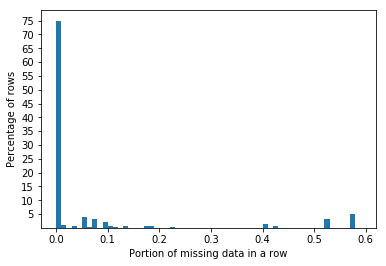

In [20]:
# How much data is missing in each row of the dataset?
num_missing = azdias_nan_col.isnull().sum(axis=1)
plt.hist(num_missing * 1.0 / azdias_nan_col.shape[1], bins=np.arange(0,0.6,step=0.01), density=True)
plt.yticks(np.arange(5,80, step=5))
plt.xlabel('Portion of missing data in a row')
plt.ylabel('Percentage of rows') # Label is accurate since bin width is 0.01.

In [21]:
# Write code to divide the data into two subsets based on the number of missing
# values in each row.

def divide_data(df, frac_nans):
    """Returns two dataframes, first with fraction of NaNs in each row > frac_nans
    and the second the complement of the first."""
    indices = df.isnull().sum(axis=1) * 1.0 / df.shape[1] > frac_nans
     
    return df[indices].copy(), df[~indices].copy()


In [22]:
azdias_manynan, azdias_fewnan = divide_data(azdias_nan_col, 0.1)
azdias_fewnan.shape

(769566, 76)

In [23]:
# Compare the distribution of values for at least five columns where there are
# no or few missing values, between the two subsets.
def compare_nans_nonans(df, frac_nans, col_name):
    df_ext = df.copy()
    manynan_indices = df_ext.isnull().sum(axis=1) * 1.0 / df.shape[1] > frac_nans
    df_ext['many_nans'] = manynan_indices
     
    ax = sns.countplot(x = col_name, hue = 'many_nans', data = df_ext)
    ax.set_xlabel(feat_dict[col_name])

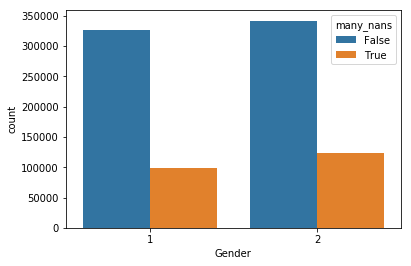

In [24]:
compare_nans_nonans(azdias_nan_col, 0, 'ANREDE_KZ')

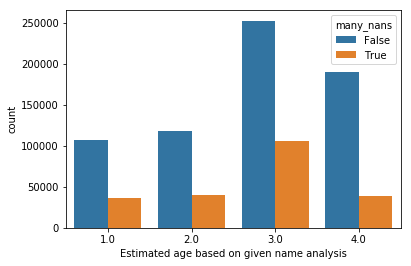

In [26]:
compare_nans_nonans(azdias_nan_col, 0, 'ALTERSKATEGORIE_GROB')

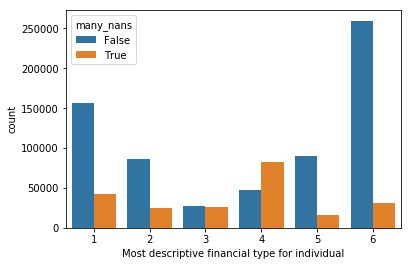

In [27]:
compare_nans_nonans(azdias_nan_col, 0, 'FINANZTYP')

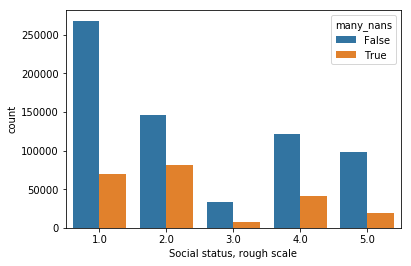

In [28]:
compare_nans_nonans(azdias_nan_col, 0, 'LP_STATUS_GROB')

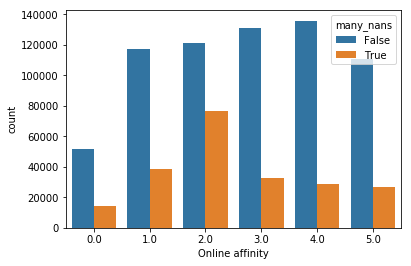

In [29]:
compare_nans_nonans(azdias_nan_col, 0, 'ONLINE_AFFINITAET')

#### Discussion 1.1.3: Assess Missing Data in Each Row

* Amount of missing data in rows: About 75% of rows have no entries missing at all and over 86% of rows have 90% or more of the data present. We will remove the rows with more than 10% of data missing and retain the rest. 

* Qualitative differences between retained rows and removed rows: I decided to check general personal features such as gender, age, financial type and social status and regional feature of online affinity (as we are studying a mail-order company). While distributions for gender and age are about the same in the retained dataset and removed dataset, the other three features present significant differences. We see that financial types 'home ownership' and 'be prepared' are over-represented in the removed dataset and 'inconspicuous' is under-represented. We also see that 'low-income earners' social status is largly under-represented in the removed dataset and 'average earners' is slightly over-represented. As for online affinity, evidently, persons living in a region with 'middle' online affinity are over-represented in the removed dataset, while persons living in a region with higher online affinity are under-represented.

* Conclusion: removed dataset is qualitatively different and therefore we will revisit it later and treat it as a separate cluster. 

### Step 1.2: Select and Re-Encode Features

Checking for missing data isn't the only way in which you can prepare a dataset for analysis. Since the unsupervised learning techniques to be used will only work on data that is encoded numerically, you need to make a few encoding changes or additional assumptions to be able to make progress. In addition, while almost all of the values in the dataset are encoded using numbers, not all of them represent numeric values. Check the third column of the feature summary (`feat_info`) for a summary of types of measurement.
- For numeric and interval data, these features can be kept without changes.
- Most of the variables in the dataset are ordinal in nature. While ordinal values may technically be non-linear in spacing, make the simplifying assumption that the ordinal variables can be treated as being interval in nature (that is, kept without any changes).
- Special handling may be necessary for the remaining two variable types: categorical, and 'mixed'.

In the first two parts of this sub-step, you will perform an investigation of the categorical and mixed-type features and make a decision on each of them, whether you will keep, drop, or re-encode each. Then, in the last part, you will create a new data frame with only the selected and engineered columns.

Data wrangling is often the trickiest part of the data analysis process, and there's a lot of it to be done here. But stick with it: once you're done with this step, you'll be ready to get to the machine learning parts of the project!

In [30]:
# How many features are there of each data type?
feat_info_trimmed = feat_info[~feat_info.attribute.isin(cols_to_remove)]
feat_info_trimmed.type.value_counts()

ordinal        46
categorical    18
numeric         6
mixed           6
Name: type, dtype: int64

In [31]:
categorical_cols = feat_info_trimmed.attribute[feat_info.type == 'categorical']
mixed_cols = feat_info_trimmed.attribute[feat_info.type == 'mixed']

#### Step 1.2.1: Re-Encode Categorical Features

For categorical data, you would ordinarily need to encode the levels as dummy variables. Depending on the number of categories, perform one of the following:
- For binary (two-level) categoricals that take numeric values, you can keep them without needing to do anything.
- There is one binary variable that takes on non-numeric values. For this one, you need to re-encode the values as numbers or create a dummy variable.
- For multi-level categoricals (three or more values), you can choose to encode the values using multiple dummy variables (e.g. via [OneHotEncoder](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html)), or (to keep things straightforward) just drop them from the analysis. As always, document your choices in the Discussion section.

In [32]:
# Assess categorical variables: which are binary, which are multi-level, and
# which one needs to be re-encoded?
binary_vals = {col:azdias_nan[col].unique() for col in categorical_cols if azdias_nan[col].nunique() < 3}
multy_vals = {col:azdias_nan[col].unique() for col in categorical_cols if azdias_nan[col].nunique() > 2}

In [33]:
binary_vals

{'ANREDE_KZ': array([1, 2]),
 'GREEN_AVANTGARDE': array([0, 1]),
 'OST_WEST_KZ': array([nan, 'W', 'O'], dtype=object),
 'SOHO_KZ': array([ nan,   1.,   0.]),
 'VERS_TYP': array([ nan,   2.,   1.])}

In [34]:
# We re-encode the only binary variable with non-numeric values. 
azdias_fewnan['OST_WEST_KZ'] = azdias_fewnan['OST_WEST_KZ'].replace({'W':0, 'O':1})

In [35]:
multy_vals

{'CAMEO_DEUG_2015': array([nan, '8', '4', '2', '6', '1', '9', '5', '7', '3'], dtype=object),
 'CAMEO_DEU_2015': array([nan, '8A', '4C', '2A', '6B', '8C', '4A', '2D', '1A', '1E', '9D',
        '5C', '8B', '7A', '5D', '9E', '9B', '1B', '3D', '4E', '4B', '3C',
        '5A', '7B', '9A', '6D', '6E', '2C', '7C', '9C', '7D', '5E', '1D',
        '8D', '6C', '6A', '5B', '4D', '3A', '2B', '7E', '3B', '6F', '5F',
        '1C'], dtype=object),
 'CJT_GESAMTTYP': array([  2.,   5.,   3.,   4.,   1.,   6.,  nan]),
 'FINANZTYP': array([4, 1, 6, 5, 2, 3]),
 'GEBAEUDETYP': array([ nan,   8.,   1.,   3.,   2.,   6.,   4.,   5.]),
 'GFK_URLAUBERTYP': array([ 10.,   1.,   5.,  12.,   9.,   3.,   8.,  11.,   4.,   2.,   7.,
          6.,  nan]),
 'LP_FAMILIE_FEIN': array([  2.,   5.,   1.,  nan,  10.,   7.,  11.,   3.,   8.,   4.,   6.,
          9.]),
 'LP_FAMILIE_GROB': array([  2.,   3.,   1.,  nan,   5.,   4.]),
 'LP_STATUS_FEIN': array([  1.,   2.,   3.,   9.,   4.,  10.,   5.,   8.,   6.,   7.,  nan])

In [36]:
# Let's translate multi-level categorical features to see if we could drop some of them without losing too much info.
for key in multy_vals.keys():
    print(key,' : ', feat_dict[key])

CJT_GESAMTTYP  :  Customer-Journey-Typology: preferred information and buying channels for
FINANZTYP  :  Most descriptive financial type for individual
GFK_URLAUBERTYP  :  Vacation habits
LP_FAMILIE_FEIN  :  Family type, fine scale
LP_FAMILIE_GROB  :  Family type, rough scale
LP_STATUS_FEIN  :  Social status, fine scale
LP_STATUS_GROB  :  Social status, rough scale
NATIONALITAET_KZ  :  Nationality based on given name analysis
SHOPPER_TYP  :  Shopper typology
ZABEOTYP  :  Energy consumption typology
GEBAEUDETYP  :  Type of building (residential vs. commercial)
CAMEO_DEUG_2015  :  German CAMEO: Wealth / Life Stage Typology, rough scale
CAMEO_DEU_2015  :  German CAMEO: Wealth / Life Stage Typology, detailed scale


In [37]:
# Re-encode categorical variable(s) to be kept in the analysis.
cat_cols_to_keep = ['CAMEO_DEUG_2015', 'CJT_GESAMTTYP', 'FINANZTYP', 'GFK_URLAUBERTYP', 'LP_FAMILIE_GROB', 
                    'LP_STATUS_GROB', 'NATIONALITAET_KZ', 'SHOPPER_TYP', 'ZABEOTYP', 'GEBAEUDETYP']
cat_cols_to_drop = ['CAMEO_DEU_2015', 'LP_STATUS_FEIN', 'LP_FAMILIE_FEIN']

azdias_fewnan = azdias_fewnan.drop(labels=cat_cols_to_drop, axis=1)

for col in cat_cols_to_keep:
    azdias_fewnan[col] = azdias_fewnan[col].astype('category')
    
azdias_fewnan_dummies = pd.get_dummies(azdias_fewnan, columns=cat_cols_to_keep, prefix_sep="__")    

In [38]:
azdias_fewnan_dummies.shape

(769566, 126)

#### Discussion 1.2.1: Re-Encode Categorical Features

* All binary features were kept unchanged except 'OST_WEST_KZ' (Building location via former East/West Germany) which was re-encoded to have 0 for West and 1 for East. 
* Considering the multi-level categorical features we notice that there are three pairs of features describing the same thing but one on a fine scale and the other on a rougher scale. I decided to drop the three features with fine scales, which are 'CAMEO_DEU_2015' (German CAMEO: Wealth / Life Stage Typology, detailed scale), 'LP_STATUS_FEIN' (Social status, fine scale) and 'LP_FAMILIE_FEIN' (Family type, fine scale). I kept the remaining 10 categorical features, switched them to type 'category' and performed one-hot-encoding. For one-hot-encoding I decided to use pandas.get_dummies instead of sklearn.preprocessing.OneHotEncoder. The advantage of the former is that it generates column names while the advantage of the latter is that it can be fitted on general population database and then used to transform the customers database. For a one-hot-encoding procedure fitting just means creating the features corresponding only to categorical values present in the database being fitted, and can be easily reproduced when I define clean_data function later. Generating column names seemed a harder task. 

#### Step 1.2.2: Engineer Mixed-Type Features

There are a handful of features that are marked as "mixed" in the feature summary that require special treatment in order to be included in the analysis. There are two in particular that deserve attention; the handling of the rest are up to your own choices:
- "PRAEGENDE_JUGENDJAHRE" combines information on three dimensions: generation by decade, movement (mainstream vs. avantgarde), and nation (east vs. west). While there aren't enough levels to disentangle east from west, you should create two new variables to capture the other two dimensions: an interval-type variable for decade, and a binary variable for movement.
- "CAMEO_INTL_2015" combines information on two axes: wealth and life stage. Break up the two-digit codes by their 'tens'-place and 'ones'-place digits into two new ordinal variables (which, for the purposes of this project, is equivalent to just treating them as their raw numeric values).
- If you decide to keep or engineer new features around the other mixed-type features, make sure you note your steps in the Discussion section.

Be sure to check `Data_Dictionary.md` for the details needed to finish these tasks.

In [39]:
for col in mixed_cols:
    print(col,' : ', feat_dict[col])

LP_LEBENSPHASE_FEIN  :  Life stage, fine scale
LP_LEBENSPHASE_GROB  :  Life stage, rough scale
PRAEGENDE_JUGENDJAHRE  :  Dominating movement of person's youth (avantgarde vs. mainstream; east vs. west)
WOHNLAGE  :  Neighborhood quality (or rural flag)
CAMEO_INTL_2015  :  German CAMEO: Wealth / Life Stage Typology, mapped to international code
PLZ8_BAUMAX  :  Most common building type within the PLZ8 region


In [40]:
mixed_vals = {col:azdias_nan[col].unique() for col in mixed_cols}
mixed_vals

{'CAMEO_INTL_2015': array([nan, '51', '24', '12', '43', '54', '22', '14', '13', '15', '33',
        '41', '34', '55', '25', '23', '31', '52', '35', '45', '44', '32'], dtype=object),
 'LP_LEBENSPHASE_FEIN': array([ 15.,  21.,   3.,  nan,  32.,   8.,   2.,   5.,  10.,   4.,   6.,
         23.,  12.,  20.,   1.,  11.,  25.,  13.,   7.,  18.,  31.,  19.,
         38.,  35.,  30.,  22.,  14.,  33.,  29.,  24.,  28.,  37.,  26.,
         39.,  27.,  36.,   9.,  34.,  40.,  16.,  17.]),
 'LP_LEBENSPHASE_GROB': array([  4.,   6.,   1.,  nan,  10.,   2.,   3.,   5.,   7.,  12.,  11.,
          9.,   8.]),
 'PLZ8_BAUMAX': array([ nan,   1.,   2.,   4.,   5.,   3.]),
 'PRAEGENDE_JUGENDJAHRE': array([ nan,  14.,  15.,   8.,   3.,  10.,  11.,   5.,   9.,   6.,   4.,
          2.,   1.,  12.,  13.,   7.]),
 'WOHNLAGE': array([ nan,   4.,   2.,   7.,   3.,   5.,   1.,   8.,   0.])}

In [41]:
# Investigate "PRAEGENDE_JUGENDJAHRE" and engineer two new variables.
PRAEGENDE_JUGENDJAHRE = azdias_fewnan_dummies['PRAEGENDE_JUGENDJAHRE']
dict_year = {1:4, 2:4, 3:5, 4:5, 5:6, 6:6, 7:6, 8:7, 9:7, 10:8, 11:8, 12:8, 13:8, 14:9, 15:9}
dict_movement = {1:0, 2:1, 3:0, 4:1, 5:0, 6:1, 7:1, 8:0, 9:1, 10:0, 11:1, 12:0, 13:1, 14:0, 15:1}
azdias_fewnan_dummies['PRAEGENDE_JUGENDJAHRE__YOUTH_DECADE'] = PRAEGENDE_JUGENDJAHRE.replace(to_replace=dict_year)
azdias_fewnan_dummies['PRAEGENDE_JUGENDJAHRE__MOVEMENT'] = PRAEGENDE_JUGENDJAHRE.replace(to_replace=dict_movement)

In [42]:
# Investigate "CAMEO_INTL_2015" and engineer two new variables.
# The first digit is household wealth, the second digit is life stage.
CAMEO_INTL_2015 = azdias_fewnan_dummies['CAMEO_INTL_2015'].replace({np.nan:0}).astype(int).replace({0:np.nan})
azdias_fewnan_dummies['CAMEO_INTL_2015__HOUSEHOLD_WEALTH'] = CAMEO_INTL_2015 // 10
azdias_fewnan_dummies['CAMEO_INTL_2015__LIFE_STAGE'] = (CAMEO_INTL_2015 % 10)

In [43]:
print(CAMEO_INTL_2015.head(3))
print(azdias_fewnan_dummies['CAMEO_INTL_2015__HOUSEHOLD_WEALTH'].head(3))
print(azdias_fewnan_dummies['CAMEO_INTL_2015__LIFE_STAGE'].head(3))

1    51.0
2    24.0
3    12.0
Name: CAMEO_INTL_2015, dtype: float64
1    5.0
2    2.0
3    1.0
Name: CAMEO_INTL_2015__HOUSEHOLD_WEALTH, dtype: float64
1    1.0
2    4.0
3    2.0
Name: CAMEO_INTL_2015__LIFE_STAGE, dtype: float64


In [44]:
# Now we are ready to drop all mixed type features. 
azdias_fewnan_dummies = azdias_fewnan_dummies.drop(labels=mixed_cols, axis=1)
azdias_fewnan_dummies.shape

(769566, 124)

In [45]:
# Save the key objects used in cleaning for later use. 
col_lists_nan_codes = dict()
col_lists_nan_codes['nan_codes'] = {key:list(value.items()) for key, value in nan_codes.items()}
col_lists_nan_codes['cols_to_remove'] = cols_to_remove
col_lists_nan_codes['cat_cols_to_keep'] = cat_cols_to_keep
col_lists_nan_codes['cat_cols_to_drop'] = cat_cols_to_drop
col_lists_nan_codes['mixed_cols'] = mixed_cols.tolist()
col_lists_nan_codes['all_cols'] = azdias_fewnan_dummies.columns.values.tolist()

with open('col_lists_nan_codes.json', 'w') as f:
    json.dump(col_lists_nan_codes, f)    

In [46]:
# We need to update the feat_dict as we have new colunms in our database:
feat_dict_newcols = {col:feat_dict[re.split(string=col, pattern=r'__')[0]]+': '+re.split(string=col, pattern=r'__')[1]
                    for col in col_lists_nan_codes['all_cols'] if re.search(string=col, pattern=r'__')}
feat_dict.update(feat_dict_newcols)

#### Discussion 1.2.2: Engineer Mixed-Type Features

* There were 6 mixed type features. Two features each were engineered from 'PRAEGENDE_JUGENDJAHRE' and 'CAMEO_INTL_2015'. Using Data_Dictionary.md I made dict_year and dict_movement to translate 'PRAEGENDE_JUGENDJAHRE' into two features with youth decade and movement. As for 'CAMEO_INTL_2015', the first digit was assigned to the new household wealth column and the second digit to the new life stage column.

* I dropped the remaining 4 features (as well as the first two) without engineering any new features from them. 


#### Step 1.2.3: Complete Feature Selection

In order to finish this step up, you need to make sure that your data frame now only has the columns that you want to keep. To summarize, the dataframe should consist of the following:
- All numeric, interval, and ordinal type columns from the original dataset.
- Binary categorical features (all numerically-encoded).
- Engineered features from other multi-level categorical features and mixed features.

Make sure that for any new columns that you have engineered, that you've excluded the original columns from the final dataset. Otherwise, their values will interfere with the analysis later on the project. For example, you should not keep "PRAEGENDE_JUGENDJAHRE", since its values won't be useful for the algorithm: only the values derived from it in the engineered features you created should be retained. As a reminder, your data should only be from **the subset with few or no missing values**.

In [47]:
# If there are other re-engineering tasks you need to perform, make sure you
# take care of them here. (Dealing with missing data will come in step 2.1.)

# Nothing to do here. azdias_fewnan_dummies is the dataframe we need. 
azdias_fewnan_dummies.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,GEBAEUDETYP__2.0,GEBAEUDETYP__3.0,GEBAEUDETYP__4.0,GEBAEUDETYP__5.0,GEBAEUDETYP__6.0,GEBAEUDETYP__8.0,PRAEGENDE_JUGENDJAHRE__YOUTH_DECADE,PRAEGENDE_JUGENDJAHRE__MOVEMENT,CAMEO_INTL_2015__HOUSEHOLD_WEALTH,CAMEO_INTL_2015__LIFE_STAGE
1,1.0,2,1,5,2,5,4,5,0,3.0,...,0,0,0,0,0,1,9.0,0.0,5.0,1.0
2,3.0,2,1,4,1,2,3,5,1,3.0,...,0,0,0,0,0,0,9.0,1.0,2.0,4.0
3,4.0,2,4,2,5,2,1,2,0,2.0,...,0,0,0,0,0,0,7.0,0.0,1.0,2.0
4,3.0,1,4,3,4,1,3,2,0,3.0,...,0,0,0,0,0,0,7.0,0.0,4.0,3.0
5,1.0,2,3,1,5,2,2,5,0,3.0,...,0,0,0,0,0,0,5.0,0.0,5.0,4.0


In [ ]:
# Do whatever you need to in order to ensure that the dataframe only contains
# the columns that should be passed to the algorithm functions.



### Step 1.3: Create a Cleaning Function

Even though you've finished cleaning up the general population demographics data, it's important to look ahead to the future and realize that you'll need to perform the same cleaning steps on the customer demographics data. In this substep, complete the function below to execute the main feature selection, encoding, and re-engineering steps you performed above. Then, when it comes to looking at the customer data in Step 3, you can just run this function on that DataFrame to get the trimmed dataset in a single step.

Note: I have added two inputs to clean_data function: cleaning_info, so that the function can be used without running all the previous cells, and frac_nans. 

In [48]:
def clean_data(df, frac_nans=0.1, cleaning_info='col_lists_nan_codes.json'):
    """
    Perform feature trimming, re-encoding, and engineering for demographics
    data
    
    INPUTs: Demographics DataFrame
            Acceptable fraction of missing values in rows
            A json file containing objects found during and used for cleaning the main dataframe
    OUTPUTs: Trimmed and cleaned demographics DataFrame
    """
    with open(cleaning_info, 'r') as f:
        info = json.load(f)  
        
    # Put in code here to execute all main cleaning steps:
    # convert missing value codes into NaNs, ...
    df = df.replace(to_replace={key:dict(value) for key, value in info['nan_codes'].items()}) 
    
    # remove selected columns and rows, ...
    df = df.drop(labels=info['cols_to_remove'], axis=1)
    
    indices = df.isnull().sum(axis=1) * 1.0 / df.shape[1] > frac_nans
    df = df[~indices].copy()
    
    # select, re-encode, and engineer column values.
    df['OST_WEST_KZ'] = df['OST_WEST_KZ'].replace({'W':0, 'O':1})
    df = df.drop(labels=info['cat_cols_to_drop'], axis=1)

    for col in info['cat_cols_to_keep']:
        df[col] = df[col].astype('category')
        
    df_dummies = pd.get_dummies(df, columns=info['cat_cols_to_keep'], prefix_sep="__") 
    
    PRAEGENDE_JUGENDJAHRE = df_dummies['PRAEGENDE_JUGENDJAHRE']
    dict_year = {1:4, 2:4, 3:5, 4:5, 5:6, 6:6, 7:6, 8:7, 9:7, 10:8, 11:8, 12:8, 13:8, 14:9, 15:9}
    dict_movement = {1:0, 2:1, 3:0, 4:1, 5:0, 6:1, 7:1, 8:0, 9:1, 10:0, 11:1, 12:0, 13:1, 14:0, 15:1}
    df_dummies['PRAEGENDE_JUGENDJAHRE__YOUTH_DECADE'] = PRAEGENDE_JUGENDJAHRE.replace(to_replace=dict_year)
    df_dummies['PRAEGENDE_JUGENDJAHRE__MOVEMENT'] = PRAEGENDE_JUGENDJAHRE.replace(to_replace=dict_movement)
    
    CAMEO_INTL_2015 = df_dummies['CAMEO_INTL_2015'].replace({np.nan:0}).astype(int).replace({0:np.nan})
    df_dummies['CAMEO_INTL_2015__HOUSEHOLD_WEALTH'] = CAMEO_INTL_2015 // 10
    df_dummies['CAMEO_INTL_2015__LIFE_STAGE'] = (CAMEO_INTL_2015 % 10)
    
    df_dummies = df_dummies.drop(labels=info['mixed_cols'], axis=1)
    
    
    # Adjust for possible missing columns from get_dummies:
    # Add missing columns and fill them with NaN's 
    missing_cols = list(set(info['all_cols']) - set(df_dummies.columns))
    for col in missing_cols:
        df_dummies[col] = 0
    # Drop any new columns
    extra_cols = list(set(df_dummies.columns) - set(info['all_cols']))
    df_dummies = df_dummies.drop(labels=extra_cols, axis=1)
    # Rearrange columns to match with the main df
    df_dummies = df_dummies[info['all_cols']]
    
    # Return the cleaned dataframe.
    return df_dummies
    
    

In [49]:
df_new = clean_data(azdias)

In [50]:
# Check if clean_data give the same dataframe as azdias_fewnan_dummies.
df_new.equals(azdias_fewnan_dummies)

True

## Step 2: Feature Transformation

### Step 2.1: Apply Feature Scaling

Before we apply dimensionality reduction techniques to the data, we need to perform feature scaling so that the principal component vectors are not influenced by the natural differences in scale for features. Starting from this part of the project, you'll want to keep an eye on the [API reference page for sklearn](http://scikit-learn.org/stable/modules/classes.html) to help you navigate to all of the classes and functions that you'll need. In this substep, you'll need to check the following:

- sklearn requires that data not have missing values in order for its estimators to work properly. So, before applying the scaler to your data, make sure that you've cleaned the DataFrame of the remaining missing values. This can be as simple as just removing all data points with missing data, or applying an [Imputer](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.Imputer.html) to replace all missing values. You might also try a more complicated procedure where you temporarily remove missing values in order to compute the scaling parameters before re-introducing those missing values and applying imputation. Think about how much missing data you have and what possible effects each approach might have on your analysis, and justify your decision in the discussion section below.
- For the actual scaling function, a [StandardScaler](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) instance is suggested, scaling each feature to mean 0 and standard deviation 1.
- For these classes, you can make use of the `.fit_transform()` method to both fit a procedure to the data as well as apply the transformation to the data at the same time. Don't forget to keep the fit sklearn objects handy, since you'll be applying them to the customer demographics data towards the end of the project.

In [51]:
# If you've not yet cleaned the dataset of all NaN values, then investigate and
# do that now.
df_nan, df_nonan = divide_data(azdias_fewnan_dummies, frac_nans=0)

In [52]:
imputer = Imputer(strategy='median')
azdias_fewnan_dummies_imputed = imputer.fit_transform(azdias_fewnan_dummies)
azdias_fewnan_dummies_imputed = pd.DataFrame(azdias_fewnan_dummies_imputed, 
                                             index=azdias_fewnan_dummies.index, 
                                             columns=azdias_fewnan_dummies.columns)

In [53]:
# Apply feature scaling to the general population demographics data.
scaler = StandardScaler()
scaler.fit(df_nonan)
azdias_scaled = pd.DataFrame(scaler.transform(azdias_fewnan_dummies_imputed),
                             index=azdias_fewnan_dummies_imputed.index,
                             columns=azdias_fewnan_dummies_imputed.columns)

In [54]:
azdias_scaled.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,GEBAEUDETYP__2.0,GEBAEUDETYP__3.0,GEBAEUDETYP__4.0,GEBAEUDETYP__5.0,GEBAEUDETYP__6.0,GEBAEUDETYP__8.0,PRAEGENDE_JUGENDJAHRE__YOUTH_DECADE,PRAEGENDE_JUGENDJAHRE__MOVEMENT,CAMEO_INTL_2015__HOUSEHOLD_WEALTH,CAMEO_INTL_2015__LIFE_STAGE
1,-1.738330,0.977328,-1.512418,1.575956,-1.042476,1.509267,1.039530,1.344051,-0.543995,1.034049,...,0.0,-0.537813,0.0,-0.001205,0.0,2.008501,1.155505,-0.543995,1.173395,-1.258316
2,0.203789,0.977328,-1.512418,0.896193,-1.763660,-0.552949,0.312296,1.344051,1.838251,1.034049,...,0.0,-0.537813,0.0,-0.001205,0.0,-0.497884,1.155505,1.838251,-0.871931,0.752104
3,1.174849,0.977328,0.685640,-0.463333,1.121078,-0.552949,-1.142171,-0.835955,-0.543995,-0.288809,...,0.0,-0.537813,0.0,-0.001205,0.0,-0.497884,-0.216437,-0.543995,-1.553707,-0.588176
4,0.203789,-1.023197,0.685640,0.216430,0.399894,-1.240354,0.312296,-0.835955,-0.543995,1.034049,...,0.0,-0.537813,0.0,-0.001205,0.0,-0.497884,-0.216437,-0.543995,0.491620,0.081964
5,-1.738330,0.977328,-0.047046,-1.143095,1.121078,-0.552949,-0.414937,1.344051,-0.543995,1.034049,...,0.0,-0.537813,0.0,-0.001205,0.0,-0.497884,-1.588378,-0.543995,1.173395,0.752104


### Discussion 2.1: Apply Feature Scaling


Enough (about 87%) of the data that was kept has no missing values, so we could expect an imputer filling the missing entries to do a good job. Moreover, I do not want to discard extra 13% of data (about 11% of the original dataset) that has very few (less than 10%) missing entries. I decided to use a median for imputing missing values as all entries are integer valued. Imputing values decreases standard deviations for columns as we introduce extra values close to the means (assuming the medians are close to the means). So, to avoid distorting the picture about variance of the data, an instance of a sklearn.preprocessing.StandardScaler with mean 0 and standard deviation 1 was fitted to the part of the data with no missing values and used to transform the imputed dataset. 

### Step 2.2: Perform Dimensionality Reduction

On your scaled data, you are now ready to apply dimensionality reduction techniques.

- Use sklearn's [PCA](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) class to apply principal component analysis on the data, thus finding the vectors of maximal variance in the data. To start, you should not set any parameters (so all components are computed) or set a number of components that is at least half the number of features (so there's enough features to see the general trend in variability).
- Check out the ratio of variance explained by each principal component as well as the cumulative variance explained. Try plotting the cumulative or sequential values using matplotlib's [`plot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.plot.html) function. Based on what you find, select a value for the number of transformed features you'll retain for the clustering part of the project.
- Once you've made a choice for the number of components to keep, make sure you re-fit a PCA instance to perform the decided-on transformation.

In [55]:
# Apply PCA to the data.
pca = PCA(random_state=2)
azdias_pca = pca.fit_transform(azdias_scaled)

In [56]:
# Investigate the variance accounted for by each principal component.

# The function below is taken from the unsupervised learning tutorials of this nanodegree with small changes. 
def scree_plot(pca, num_components):
    '''
    Creates a scree plot associated with the num_components-many principal components 
    
    INPUTs: pca - the result of instantian of PCA in scikit learn, 
            num_components - the number of components to display
            
    OUTPUT:
            None
    '''
    num_components=min(len(pca.explained_variance_ratio_),num_components)
    ind = np.arange(num_components)
    vals = pca.explained_variance_ratio_[:num_components]
 
    plt.figure(figsize=(20, 6))
    ax = plt.subplot(111)
    cumvals = np.cumsum(vals)
    ax.bar(ind, vals)
    ax.plot(ind, cumvals)
    for i in range(num_components):
        ax.annotate(r"%s%%" % ((str(vals[i]*100)[:4])), (ind[i], vals[i]+0.01), va="bottom", ha="center", fontsize=12, rotation=90)
 
    ax.set_yticks(ticks=np.arange(0, 1, step=0.1))
    ax.xaxis.set_tick_params(width=0)
    ax.yaxis.set_tick_params(width=2, length=12)
 
    ax.set_xlabel("Principal Component")
    ax.set_ylabel("Variance Explained (%)")
    plt.title('Explained Variance Per Principal Component')


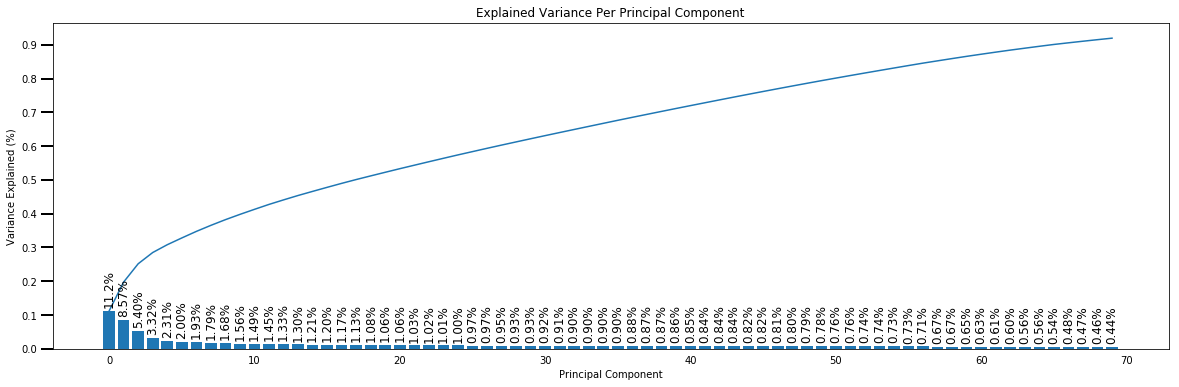

In [57]:
scree_plot(pca, 70)

In [58]:
np.min(np.argwhere(np.cumsum(pca.explained_variance_ratio_) > 0.85))+1

58

In [59]:
# Re-apply PCA to the data while selecting for number of components to retain.
pca60 = PCA(n_components=60, random_state=2)
azdias_pca60 = pca60.fit_transform(azdias_scaled)

In [60]:
azdias_pca60 = pd.DataFrame(azdias_pca60,
                            index=azdias_scaled.index,
                            columns=['PCA:{}'.format(i) for i in range(azdias_pca60.shape[1])])

In [61]:
azdias_pca = pd.DataFrame(azdias_pca,
                          index=azdias_scaled.index,
                          columns=['PCA:{}'.format(i) for i in range(azdias_pca.shape[1])])

### Discussion 2.2: Perform Dimensionality Reduction

We see from the plot that, after 25 components, each new component accounts for less than 1% of variability in data and only the first three components account for more than 5% of variability. I would like to account for 85% of variability in data, for which we need at least 58 components. So, I will refit pca with 60 componens. Lastly, the transformed dataset is made into a dataframe. 

### Step 2.3: Interpret Principal Components

Now that we have our transformed principal components, it's a nice idea to check out the weight of each variable on the first few components to see if they can be interpreted in some fashion.

As a reminder, each principal component is a unit vector that points in the direction of highest variance (after accounting for the variance captured by earlier principal components). The further a weight is from zero, the more the principal component is in the direction of the corresponding feature. If two features have large weights of the same sign (both positive or both negative), then increases in one tend to be associated with increases in the other. To contrast, features with different signs can be expected to show a negative correlation: increases in one variable should result in a decrease in the other.

- To investigate the features, you should map each weight to their corresponding feature name, then sort the features according to weight. The most interesting features for each principal component, then, will be those at the beginning and end of the sorted list. Use the data dictionary document to help you understand these most prominent features, their relationships, and what a positive or negative value on the principal component might indicate.
- You should investigate and interpret feature associations from the first three principal components in this substep. To help facilitate this, you should write a function that you can call at any time to print the sorted list of feature weights, for the *i*-th principal component. This might come in handy in the next step of the project, when you interpret the tendencies of the discovered clusters.

In [62]:
# Map weights for the first principal component to corresponding feature names
# and then print the linked values, sorted by weight.
# HINT: Try defining a function here or in a new cell that you can reuse in the
# other cells.

def map_weights_to_features(df, pca, comp=0, ascending=False, print_n=3):

    features = [feat_dict[col] for col in df.columns]
    # PCA components
    weights = pd.DataFrame({'Dimension{}'.format(comp):np.round(pca.components_[comp], 4), 'Features':features},
                           index = df.columns)
    weights_sorted = weights.sort_values(by=['Dimension{}'.format(comp)], ascending=ascending)
    
    weights_n = pd.concat([weights_sorted[:print_n], weights_sorted[-print_n:]])
    
    print(weights_n)

    # Return a concatenated DataFrame
    return weights_sorted
    

In [63]:
weights_sorted_0 = map_weights_to_features(azdias_scaled, pca60, comp=0)

                     Dimension0  \
LP_STATUS_GROB__1.0      0.1998   
PLZ8_ANTG3               0.1884   
HH_EINKOMMEN_SCORE       0.1873   
KBA05_ANTG1             -0.1898   
MOBI_REGIO              -0.2062   
FINANZ_MINIMALIST       -0.2123   

                                                            Features  
LP_STATUS_GROB__1.0                  Social status, rough scale: 1.0  
PLZ8_ANTG3           Number of 6-10 family houses in the PLZ8 region  
HH_EINKOMMEN_SCORE                    Estimated household net income  
KBA05_ANTG1             Number of 1-2 family houses in the microcell  
MOBI_REGIO                                         Movement patterns  
FINANZ_MINIMALIST        Financial dimension: low financial interest  


In [64]:
# Map weights for the second principal component to corresponding feature names
# and then print the linked values, sorted by weight.

weights_sorted_1 = map_weights_to_features(azdias_scaled, pca60, comp=1)

                                     Dimension1  \
ALTERSKATEGORIE_GROB                     0.2238   
FINANZ_VORSORGER                         0.2083   
ZABEOTYP__3                              0.2049   
FINANZ_UNAUFFAELLIGER                   -0.2132   
SEMIO_REL                               -0.2206   
PRAEGENDE_JUGENDJAHRE__YOUTH_DECADE     -0.2253   

                                                                              Features  
ALTERSKATEGORIE_GROB                        Estimated age based on given name analysis  
FINANZ_VORSORGER                                      Financial dimension: be prepared  
ZABEOTYP__3                                             Energy consumption typology: 3  
FINANZ_UNAUFFAELLIGER                               Financial dimension: inconspicuous  
SEMIO_REL                                             Personality dimension: religious  
PRAEGENDE_JUGENDJAHRE__YOUTH_DECADE  Dominating movement of person's youth (avantga...  


In [65]:
# Map weights for the third principal component to corresponding feature names
# and then print the linked values, sorted by weight.

weights_sorted_2 = map_weights_to_features(azdias_scaled, pca60, comp=2)

            Dimension2                                   Features
SEMIO_VERT      0.3329            Personality dimension: dreamful
SEMIO_SOZ       0.2575     Personality dimension: socially-minded
SEMIO_FAM       0.2545       Personality dimension: family-minded
SEMIO_DOM      -0.2900     Personality dimension: dominant-minded
SEMIO_KAEM     -0.3180  Personality dimension: combative attitude
ANREDE_KZ      -0.3531                                     Gender


### Discussion 2.3: Interpret Principal Components

As it was mentioned above, features with high weights for a given PCA component tend to be in the direction of that component and therefore be correlated: positively if their weights have the same sign and negatively if their weights have the opposite signs. Also, we know that PCA features are decorrelated (orthogonal). So, if two features tend to be in the direction of two distinct PCA features, we could expect them to have close to 0 correlation, i.e. expect change in one to not give any clear trend in the change of the other. So, features grouped by the components they are associated with tend to be independent inter-group and correlated (positively intra-same-sign-subgroups or negatively inter-same-sign-subgroups) intra-group. For instance, 'Personality dimension: socially-minded' and 'Personality dimension: family-minded' tend to be positively correlated: the more socially-minded a person is the more family-minded they would likely to be; 'Personality dimension: socially-minded' and 'Personality dimension: dominant-minded' tend to be negatively correlated; while 'Personality dimension: socially-minded' would likely be independent of PRAEGENDE_JUGENDJAHRE__YOUTH_DECADE and 'Estimated household net income'. 

The first three PCA components account for about 25% of the variability in the data. Therefore, observing features with highest weights for these three vectors could give us an idea about three key pairwise independent aspects of persons in our database, and consequently how to interpret the first three coordinates in a given row of our transformed database. 

So, roughly speaking and after confering with Data_Dictionary.md to note how high and low values are to be interpreted, a positive large coordinate in the first component for a given row would suggest a person that tends to:
* earn a low-income and have low estimated household net income, 
* live in an apartment building in a densely populated area (in a region with high humber of 6-10 family houses and a microcell with lower number of 1-2 family houses),
* move a lot,
* not save or invest much. 

Similarly, a positive large coordinate in the second component for a given row would suggest a person that tends to:
* be older (high estimated age, low youth decade),
* be driven by fairness of supply in energy consumption,
* be religious 
* have inconspicuous financial circumstances with low preparedness.  

And lastly, a positive large coordinate in the third component for a given row would suggest a person that tends to:
* not be dreamful, socially-minded or family-minded, 
* be dominant-minded and have compabative attitude,
* be male

Large negative coordinates would, respectively, indicate opposites of each of the points mentioned. 

## Step 3: Clustering

### Step 3.1: Apply Clustering to General Population

You've assessed and cleaned the demographics data, then scaled and transformed them. Now, it's time to see how the data clusters in the principal components space. In this substep, you will apply k-means clustering to the dataset and use the average within-cluster distances from each point to their assigned cluster's centroid to decide on a number of clusters to keep.

- Use sklearn's [KMeans](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html#sklearn.cluster.KMeans) class to perform k-means clustering on the PCA-transformed data.
- Then, compute the average difference from each point to its assigned cluster's center. **Hint**: The KMeans object's `.score()` method might be useful here, but note that in sklearn, scores tend to be defined so that larger is better. Try applying it to a small, toy dataset, or use an internet search to help your understanding.
- Perform the above two steps for a number of different cluster counts. You can then see how the average distance decreases with an increasing number of clusters. However, each additional cluster provides a smaller net benefit. Use this fact to select a final number of clusters in which to group the data. **Warning**: because of the large size of the dataset, it can take a long time for the algorithm to resolve. The more clusters to fit, the longer the algorithm will take. You should test for cluster counts through at least 10 clusters to get the full picture, but you shouldn't need to test for a number of clusters above about 30.
- Once you've selected a final number of clusters to use, re-fit a KMeans instance to perform the clustering operation. Make sure that you also obtain the cluster assignments for the general demographics data, since you'll be using them in the final Step 3.3.

In [83]:
# Over a number of different cluster counts...
# This was run before random_state was set. I decided not to rerun it since it took a long time. 
scores=[]
for i in range(2,21):
    print('Running kmeans with {} clusters...'.format(i))
    # run k-means clustering on the data and...
    kmeans = KMeans(n_clusters=i, random_state=2)
    kmeans.fit(azdias_pca60)
    
    # compute the average within-cluster distances.
    score = kmeans.inertia_ / azdias_pca60.shape[0]
    scores.append(score)
    print("Score: {:.0f}\n".format(score))

Running kmeans with 2 clusters...
Score: 95

Running kmeans with 3 clusters...
Score: 90

Running kmeans with 4 clusters...
Score: 87

Running kmeans with 5 clusters...
Score: 85

Running kmeans with 6 clusters...
Score: 83

Running kmeans with 7 clusters...
Score: 81

Running kmeans with 8 clusters...
Score: 80

Running kmeans with 9 clusters...
Score: 79

Running kmeans with 10 clusters...
Score: 78

Running kmeans with 11 clusters...
Score: 77

Running kmeans with 12 clusters...
Score: 76

Running kmeans with 13 clusters...
Score: 75

Running kmeans with 14 clusters...
Score: 75

Running kmeans with 15 clusters...
Score: 75

Running kmeans with 16 clusters...
Score: 74

Running kmeans with 17 clusters...
Score: 73

Running kmeans with 18 clusters...
Score: 73

Running kmeans with 19 clusters...
Score: 72

Running kmeans with 20 clusters...
Score: 72



In [84]:
with open('scores.json', 'w') as f:
    json.dump(scores, f) 

Text(0.5,1,'Average squared distance from centroids vs. Number of clusters')

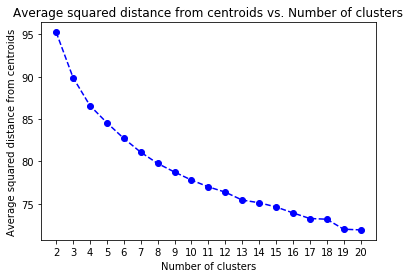

In [85]:
# Investigate the change in within-cluster distance across number of clusters.
# HINT: Use matplotlib's plot function to visualize this relationship.
with open('scores.json', 'r') as f:
    scores = json.load(f)

plt.plot(range(2,21), scores, linestyle='--', marker='o', color='b')
plt.xticks(np.arange(2, 21, step=1))
plt.xlabel('Number of clusters')
plt.ylabel('Average squared distance from centroids')
plt.title('Average squared distance from centroids vs. Number of clusters')


In [66]:
# Re-fit the k-means model with the selected number of clusters and obtain
# cluster predictions for the general population demographics data.
kmeans_13 = KMeans(n_clusters=13, random_state=2)
kmeans_13.fit(azdias_pca60)
azdias_clusters = kmeans_13.predict(azdias_pca60)

In [67]:
azdias_clusters = pd.Series(azdias_clusters, name='Azdias_Cluster_labels', index=azdias_pca60.index)
azdias_cluster_counts = azdias_clusters.value_counts()

### Discussion 3.1: Apply Clustering to General Population

Clustering has been performed for number of clusters ranging from 2 to 20 and corresponding average within-cluster distance have been computed and plotted. We are looking for an elbow point on the plot, i.e. a number of clusters k such that average within-cluster distance decreases comparatively fast before k than after k. From the plot either of k=7 or k=13 could be picked. I decided to choose k=13 as I would like to see a finer subdivision considering the large number of features in the dataset. 

### Step 3.2: Apply All Steps to the Customer Data

Now that you have clusters and cluster centers for the general population, it's time to see how the customer data maps on to those clusters. Take care to not confuse this for re-fitting all of the models to the customer data. Instead, you're going to use the fits from the general population to clean, transform, and cluster the customer data. In the last step of the project, you will interpret how the general population fits apply to the customer data.

- Don't forget when loading in the customers data, that it is semicolon (`;`) delimited.
- Apply the same feature wrangling, selection, and engineering steps to the customer demographics using the `clean_data()` function you created earlier. (You can assume that the customer demographics data has similar meaning behind missing data patterns as the general demographics data.)
- Use the sklearn objects from the general demographics data, and apply their transformations to the customers data. That is, you should not be using a `.fit()` or `.fit_transform()` method to re-fit the old objects, nor should you be creating new sklearn objects! Carry the data through the feature scaling, PCA, and clustering steps, obtaining cluster assignments for all of the data in the customer demographics data.

In [68]:
# Load in the customer demographics data.
customers = pd.read_csv("Udacity_CUSTOMERS_Subset.csv", sep=';')

In [69]:
# Apply preprocessing, feature transformation, and clustering from the general
# demographics onto the customer data, obtaining cluster predictions for the
# customer demographics data.

# Preprocessing
customers_cleaned = clean_data(customers, frac_nans=0.1)

In [70]:
customers_cleaned.shape

(135678, 124)

In [71]:
# Feature transformation
customers_imputed = imputer.transform(customers_cleaned)
customers_imputed = pd.DataFrame(customers_imputed,
                                 index=customers_cleaned.index,
                                 columns=customers_cleaned.columns)

customers_scaled = pd.DataFrame(scaler.transform(customers_imputed),
                                index=customers_imputed.index,
                                columns=customers_imputed.columns)

customers_pca60 = pca60.transform(customers_scaled)
customers_pca60 = pd.DataFrame(customers_pca60,
                            index=customers_scaled.index,
                            columns=['PCA:{}'.format(i) for i in range(customers_pca60.shape[1])])

In [72]:
# Clustering 
customers_clusters = kmeans_13.predict(customers_pca60)
customers_clusters = pd.Series(customers_clusters, name='Customers_Cluster_labels', index=customers_pca60.index)
customers_cluster_counts = customers_clusters.value_counts()

### Step 3.3: Compare Customer Data to Demographics Data

At this point, you have clustered data based on demographics of the general population of Germany, and seen how the customer data for a mail-order sales company maps onto those demographic clusters. In this final substep, you will compare the two cluster distributions to see where the strongest customer base for the company is.

Consider the proportion of persons in each cluster for the general population, and the proportions for the customers. If we think the company's customer base to be universal, then the cluster assignment proportions should be fairly similar between the two. If there are only particular segments of the population that are interested in the company's products, then we should see a mismatch from one to the other. If there is a higher proportion of persons in a cluster for the customer data compared to the general population (e.g. 5% of persons are assigned to a cluster for the general population, but 15% of the customer data is closest to that cluster's centroid) then that suggests the people in that cluster to be a target audience for the company. On the other hand, the proportion of the data in a cluster being larger in the general population than the customer data (e.g. only 2% of customers closest to a population centroid that captures 6% of the data) suggests that group of persons to be outside of the target demographics.

Take a look at the following points in this step:

- Compute the proportion of data points in each cluster for the general population and the customer data. Visualizations will be useful here: both for the individual dataset proportions, but also to visualize the ratios in cluster representation between groups. Seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) or [`barplot()`](https://seaborn.pydata.org/generated/seaborn.barplot.html) function could be handy.
  - Recall the analysis you performed in step 1.1.3 of the project, where you separated out certain data points from the dataset if they had more than a specified threshold of missing values. If you found that this group was qualitatively different from the main bulk of the data, you should treat this as an additional data cluster in this analysis. Make sure that you account for the number of data points in this subset, for both the general population and customer datasets, when making your computations!
- Which cluster or clusters are overrepresented in the customer dataset compared to the general population? Select at least one such cluster and infer what kind of people might be represented by that cluster. Use the principal component interpretations from step 2.3 or look at additional components to help you make this inference. Alternatively, you can use the `.inverse_transform()` method of the PCA and StandardScaler objects to transform centroids back to the original data space and interpret the retrieved values directly.
- Perform a similar investigation for the underrepresented clusters. Which cluster or clusters are underrepresented in the customer dataset compared to the general population, and what kinds of people are typified by these clusters?

In [73]:
# Compare the proportion of data in each cluster for the customer data to the
# proportion of data in each cluster for the general population.
azdias_numnans = azdias.shape[0] - azdias_scaled.shape[0]
customers_numnans = customers.shape[0] - customers_scaled.shape[0]

In [74]:
azdias_cluster_counts = azdias_cluster_counts.append(pd.Series([azdias_numnans], index=[13]))

In [75]:
customers_cluster_counts = customers_cluster_counts.append(pd.Series([customers_numnans], index=[13]))

In [76]:
azdias_cluster_proportions = azdias_cluster_counts / azdias_cluster_counts.sum()
customers_cluster_proportions = customers_cluster_counts / customers_cluster_counts.sum()
print(azdias_cluster_proportions.sort_values(ascending=False))
print(customers_cluster_proportions.sort_values(ascending=False))

13    0.136504
1     0.099952
9     0.095709
11    0.094992
12    0.081807
5     0.079666
2     0.075338
3     0.067022
4     0.056580
7     0.055632
10    0.051833
0     0.047253
8     0.031402
6     0.026311
dtype: float64
13    0.292061
4     0.230517
5     0.123343
7     0.080552
1     0.074385
11    0.061168
2     0.054093
0     0.025030
6     0.018356
8     0.013159
12    0.008500
10    0.007268
9     0.006460
3     0.005108
dtype: float64


In [77]:
customers_to_azdias_ratio = customers_cluster_proportions.divide(azdias_cluster_proportions)
customers_minus_azdias = customers_cluster_proportions - azdias_cluster_proportions

In [78]:
print(customers_to_azdias_ratio.sort_values())

9     0.067492
3     0.076218
12    0.103901
10    0.140226
8     0.419060
0     0.529695
11    0.643929
6     0.697660
2     0.718000
1     0.744208
7     1.447960
5     1.548256
13    2.139580
4     4.074197
dtype: float64


Text(0,0.5,'Cluster proportion differences (customers-azdias)')

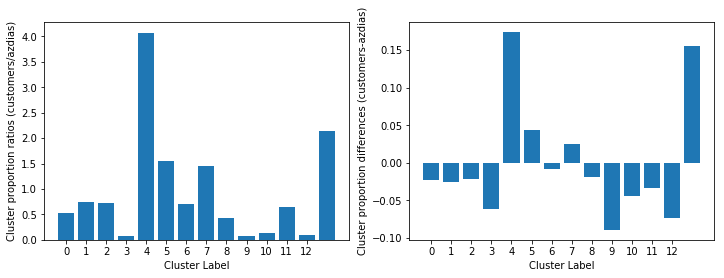

In [80]:
_, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12,4))

ax1.bar(customers_to_azdias_ratio.index.values, customers_to_azdias_ratio)
ax1.set_xticks(np.arange(0,13, step=1))
ax1.set_xlabel('Cluster Label')
ax1.set_ylabel('Cluster proportion ratios (customers/azdias)')

ax2.bar(customers_minus_azdias.index.values, customers_minus_azdias)
ax2.set_xticks(np.arange(0,13, step=1))
ax2.set_xlabel('Cluster Label')
ax2.set_ylabel('Cluster proportion differences (customers-azdias)')

In [81]:
# Find the inverse of the centers to interpret clusters
centers_pca = kmeans_13.cluster_centers_
centers_scaled = pca60.inverse_transform(centers_pca)
centers = scaler.inverse_transform(centers_scaled)
centers_df = pd.DataFrame(np.round(centers), 
                          index=['Center{}'.format(i) for i in range(kmeans_13.cluster_centers_.shape[0])],
                          columns=azdias_fewnan_dummies.columns)

In [82]:
# Extract the cluster corresponding to the removed data points. 
azdias_manynan = clean_data(azdias, frac_nans=1)
azdias_manynan = azdias_manynan.loc[azdias_manynan.index.difference(azdias_fewnan_dummies.index), :]

# Calculate medians of columns of the database of removed points. 
cluster_center_13 = azdias_manynan.median(axis=0, skipna=True).to_frame().T
cluster_center_13.columns = centers_df.columns
cluster_center_13.index = ['RemovedPoints']

# Put all centers together. 
all_centers_df = pd.concat([centers_df, cluster_center_13])

In [83]:
# We limit ourselves to features corresponding to the first three PCA components. 
pca0_cols = weights_sorted_0['Dimension0'].abs().sort_values(ascending=False)[:6].index.values.tolist()
pca1_cols = weights_sorted_1['Dimension1'].abs().sort_values(ascending=False)[:6].index.values.tolist()
pca2_cols = weights_sorted_2['Dimension2'].abs().sort_values(ascending=False)[:6].index.values.tolist()
pca_cols = list(set().union(pca0_cols, pca1_cols, pca2_cols))

In [84]:
all_centers_df[pca_cols]

,ALTERSKATEGORIE_GROB,MOBI_REGIO,FINANZ_SPARER,KBA05_ANTG1,PLZ8_ANTG3,LP_STATUS_GROB__1.0,SEMIO_KAEM,PRAEGENDE_JUGENDJAHRE__YOUTH_DECADE,SEMIO_KRIT,FINANZ_UNAUFFAELLIGER,SEMIO_VERT,ANREDE_KZ,SEMIO_REL,FINANZ_VORSORGER,PLZ8_ANTG1,FINANZ_MINIMALIST,SEMIO_SOZ,SEMIO_DOM
Center0,3.0,1.0,2.0,0.0,2.0,1.0,5.0,7.0,5.0,2.0,4.0,2.0,3.0,4.0,1.0,3.0,4.0,5.0
Center1,3.0,2.0,2.0,1.0,2.0,1.0,3.0,6.0,4.0,2.0,6.0,1.0,4.0,4.0,2.0,3.0,5.0,3.0
Center2,4.0,4.0,2.0,2.0,1.0,0.0,5.0,6.0,6.0,2.0,3.0,2.0,2.0,4.0,3.0,4.0,3.0,5.0
Center3,2.0,2.0,4.0,0.0,2.0,1.0,2.0,9.0,3.0,4.0,6.0,1.0,6.0,2.0,1.0,2.0,7.0,3.0
Center4,3.0,4.0,2.0,3.0,1.0,0.0,3.0,6.0,3.0,2.0,6.0,1.0,4.0,4.0,3.0,5.0,5.0,3.0
Center5,3.0,4.0,2.0,3.0,1.0,0.0,3.0,7.0,4.0,2.0,6.0,1.0,4.0,4.0,3.0,5.0,5.0,3.0
Center6,3.0,4.0,3.0,2.0,1.0,0.0,4.0,8.0,5.0,3.0,5.0,2.0,4.0,3.0,3.0,4.0,3.0,4.0
Center7,3.0,4.0,2.0,3.0,1.0,0.0,6.0,7.0,6.0,2.0,3.0,2.0,2.0,4.0,3.0,4.0,3.0,6.0
Center8,2.0,4.0,4.0,3.0,1.0,-0.0,4.0,9.0,4.0,4.0,5.0,1.0,5.0,2.0,3.0,4.0,5.0,4.0
Center9,2.0,2.0,4.0,0.0,2.0,1.0,6.0,9.0,5.0,4.0,2.0,2.0,5.0,2.0,2.0,1.0,3.0,6.0


In [85]:
# Make dictionaries to translate values in each column to their interpretations from Data_Dictionary.md
sections_list = re.split(pattern=re.compile('### \d{1}\.\d{1,2}. '), string=data_dictionary)[1:]
sections_list1 = [re.sub(pattern='\nDimension translations:\n(.*\n)*', string=sections_list[i], repl='')
                 for i in range(len(sections_list))]
sections_list2 = [re.sub(pattern=',\n###\s+', string=sections_list1[i], repl=', ')
                 for i in range(len(sections_list1))]
sections_dict = {re.findall(pattern='^(.*)', string=sections_list2[i])[0]:
                 {int(re.findall(pattern='-\s+(-*\d+): (.*)', string=sections_list2[i])[j][0]):
                 re.findall(pattern='-\s+(-*\d+): (.*)', string=sections_list2[i])[j][1]
                 for j in range(len(re.findall(pattern='-\s+(-*\d+): (.*)', string=sections_list2[i])))}
                 for i in range(len(sections_list2))}
sections_dict['OST_WEST_KZ'] = {0:'W', 1:'O'}
sections_dict['PRAEGENDE_JUGENDJAHRE__YOUTH_DECADE'] = {4:'40s', 5:'50s', 6:'60s', 7:'70s', 8:'80s', 9:'90s'}
sections_dict['PRAEGENDE_JUGENDJAHRE__MOVEMENT'] = {0:'Mainstream', 1:'Avantgarde'}
sections_dict['CAMEO_INTL_2015__HOUSEHOLD_WEALTH'] = {1:'Wealthy Households', 2:'Prosperous Households',
                                                      3:'Comfortable Households', 4:'Less Affluent Households',
                                                      5:'Poorer Households'}
sections_dict['CAMEO_INTL_2015__LIFE_STAGE'] = {1:'Pre-Family Couples & Singles', 2:'Young Couples With Children',
                                                3:'Families With School Age Children', 
                                                4:'Older Families &  Mature Couples', 
                                                5:'Elders In Retirement'}

multi_feature_items = [{new_key:value for new_key in re.split(pattern=', ', string=key)} 
                            for key, value in sections_dict.items() 
                            if re.search(pattern=', ', string=key)]
for feature_group in multi_feature_items:
    sections_dict.update(feature_group)
    
remaining_cols = set(centers_df.columns.values.tolist()) - set(list(sections_dict))
remaining_cols_dict = {col:{0:'0', 1:sections_dict[re.split(pattern='__', string=col)[0]][float(re.split(pattern='__', string=col)[1])]} for col in remaining_cols}
sections_dict.update(remaining_cols_dict)    

In [86]:
# Translate values.
all_centers_df_interpreted = all_centers_df.copy()
all_centers_df_interpreted = all_centers_df_interpreted.replace(to_replace=sections_dict)
all_centers_df_interpreted.columns = [feat_dict[col] for col in all_centers_df.columns]   

In [87]:
all_centers_df_interpreted[[feat_dict[col] for col in pca_cols]]

,Estimated age based on given name analysis,Movement patterns,Financial dimension: money-saver,Number of 1-2 family houses in the microcell,Number of 6-10 family houses in the PLZ8 region,"Social status, rough scale: 1.0",Personality dimension: combative attitude,Dominating movement of person's youth (avantgarde vs. mainstream; east vs. west): YOUTH_DECADE,Personality dimension: critical-minded,Financial dimension: inconspicuous,Personality dimension: dreamful,Gender,Personality dimension: religious,Financial dimension: be prepared,Number of 1-2 family houses in the PLZ8 region,Financial dimension: low financial interest,Personality dimension: socially-minded,Personality dimension: dominant-minded
Center0,46 - 60 years old,very high movement,high,no 1-2 family homes,average share of 6-10 family homes,low-income earners (maps to 1-2 in fine scale),low affinity,70s,low affinity,high,average affinity,female,high affinity,low,lower share of 1-2 family homes,average,average affinity,low affinity
Center1,46 - 60 years old,high movement,high,lower share of 1-2 family homes,average share of 6-10 family homes,low-income earners (maps to 1-2 in fine scale),high affinity,60s,average affinity,high,very low affinity,male,average affinity,low,average share of 1-2 family homes,average,low affinity,high affinity
Center2,> 60 years old,low movement,high,average share of 1-2 family homes,lower share of 6-10 family homes,0,low affinity,60s,very low affinity,high,high affinity,female,very high affinity,low,high share of 1-2 family homes,low,high affinity,low affinity
Center3,30 - 45 years old,high movement,low,no 1-2 family homes,average share of 6-10 family homes,low-income earners (maps to 1-2 in fine scale),very high affinity,90s,high affinity,low,very low affinity,male,very low affinity,high,lower share of 1-2 family homes,high,lowest affinity,high affinity
Center4,46 - 60 years old,low movement,high,high share of 1-2 family homes,lower share of 6-10 family homes,0,high affinity,60s,high affinity,high,very low affinity,male,average affinity,low,high share of 1-2 family homes,very low,low affinity,high affinity
Center5,46 - 60 years old,low movement,high,high share of 1-2 family homes,lower share of 6-10 family homes,0,high affinity,70s,average affinity,high,very low affinity,male,average affinity,low,high share of 1-2 family homes,very low,low affinity,high affinity
Center6,46 - 60 years old,low movement,average,average share of 1-2 family homes,lower share of 6-10 family homes,0,average affinity,80s,low affinity,average,low affinity,female,average affinity,average,high share of 1-2 family homes,low,high affinity,average affinity
Center7,46 - 60 years old,low movement,high,high share of 1-2 family homes,lower share of 6-10 family homes,0,very low affinity,70s,very low affinity,high,high affinity,female,very high affinity,low,high share of 1-2 family homes,low,high affinity,very low affinity
Center8,30 - 45 years old,low movement,low,high share of 1-2 family homes,lower share of 6-10 family homes,0,average affinity,90s,average affinity,low,low affinity,male,low affinity,high,high share of 1-2 family homes,low,low affinity,average affinity
Center9,30 - 45 years old,high movement,low,no 1-2 family homes,average share of 6-10 family homes,low-income earners (maps to 1-2 in fine scale),very low affinity,90s,low affinity,low,very high affinity,female,low affinity,high,average share of 1-2 family homes,very high,high affinity,very low affinity


In [88]:
# What kinds of people are part of a cluster that is overrepresented in the
# customer data compared to the general population?

# All four over-represented clusters from the most over-represented to the least.
all_centers_df_interpreted[[feat_dict[col] for col in pca_cols]].loc[['Center4', 'RemovedPoints', 'Center5', 'Center7'],:]

,Estimated age based on given name analysis,Movement patterns,Financial dimension: money-saver,Number of 1-2 family houses in the microcell,Number of 6-10 family houses in the PLZ8 region,"Social status, rough scale: 1.0",Personality dimension: combative attitude,Dominating movement of person's youth (avantgarde vs. mainstream; east vs. west): YOUTH_DECADE,Personality dimension: critical-minded,Financial dimension: inconspicuous,Personality dimension: dreamful,Gender,Personality dimension: religious,Financial dimension: be prepared,Number of 1-2 family houses in the PLZ8 region,Financial dimension: low financial interest,Personality dimension: socially-minded,Personality dimension: dominant-minded
Center4,46 - 60 years old,low movement,high,high share of 1-2 family homes,lower share of 6-10 family homes,0,high affinity,60s,high affinity,high,very low affinity,male,average affinity,low,high share of 1-2 family homes,very low,low affinity,high affinity
RemovedPoints,46 - 60 years old,middle movement,low,lower share of 1-2 family homes,lower share of 6-10 family homes,0,very low affinity,80s,lowest affinity,very low,highest affinity,female,lowest affinity,average,average share of 1-2 family homes,average,very high affinity,very low affinity
Center5,46 - 60 years old,low movement,high,high share of 1-2 family homes,lower share of 6-10 family homes,0,high affinity,70s,average affinity,high,very low affinity,male,average affinity,low,high share of 1-2 family homes,very low,low affinity,high affinity
Center7,46 - 60 years old,low movement,high,high share of 1-2 family homes,lower share of 6-10 family homes,0,very low affinity,70s,very low affinity,high,high affinity,female,very high affinity,low,high share of 1-2 family homes,low,high affinity,very low affinity


In [89]:
# What kinds of people are part of a cluster that is underrepresented in the
# customer data compared to the general population?

# The four most under-represented clusters from the most under-represented to the least.
all_centers_df_interpreted[[feat_dict[col] for col in pca_cols]].loc[['Center9', 'Center3', 'Center12', 'Center10'],:]

,Estimated age based on given name analysis,Movement patterns,Financial dimension: money-saver,Number of 1-2 family houses in the microcell,Number of 6-10 family houses in the PLZ8 region,"Social status, rough scale: 1.0",Personality dimension: combative attitude,Dominating movement of person's youth (avantgarde vs. mainstream; east vs. west): YOUTH_DECADE,Personality dimension: critical-minded,Financial dimension: inconspicuous,Personality dimension: dreamful,Gender,Personality dimension: religious,Financial dimension: be prepared,Number of 1-2 family houses in the PLZ8 region,Financial dimension: low financial interest,Personality dimension: socially-minded,Personality dimension: dominant-minded
Center9,30 - 45 years old,high movement,low,no 1-2 family homes,average share of 6-10 family homes,low-income earners (maps to 1-2 in fine scale),very low affinity,90s,low affinity,low,very high affinity,female,low affinity,high,average share of 1-2 family homes,very high,high affinity,very low affinity
Center3,30 - 45 years old,high movement,low,no 1-2 family homes,average share of 6-10 family homes,low-income earners (maps to 1-2 in fine scale),very high affinity,90s,high affinity,low,very low affinity,male,very low affinity,high,lower share of 1-2 family homes,high,lowest affinity,high affinity
Center12,30 - 45 years old,low movement,low,average share of 1-2 family homes,lower share of 6-10 family homes,0,very low affinity,90s,low affinity,low,high affinity,female,low affinity,high,high share of 1-2 family homes,high,high affinity,very low affinity
Center10,30 - 45 years old,low movement,low,average share of 1-2 family homes,lower share of 6-10 family homes,0,very high affinity,90s,high affinity,low,very low affinity,male,very low affinity,high,high share of 1-2 family homes,average,very low affinity,high affinity


### Discussion 3.3: Compare Customer Data to Demographics Data

There are four over-represented clusters, 4, 13(removed points), 5 and 7, in order from the most over-represented to the least. All other clusters are under-represented to various degrees. The four most under-represented clusters are 9, 3, 12 and 10, in order from the most under-represented to the least. 

To understand the cluster centers I performed inverses of PCA and StandardScaler. To find a typical representative of the cluster of removed points I cleaned the dataframe of these points and calculated the medians for columns. As all feature names and values have been replaced by the respective interpretations, we just need to look at the dataframe of centers to read off the characteristics of persons typified by these clusters. Also, instead of looking at 124 features I will restrict my attention to 18: for each of the first three PCA components I have already picked 6 features with the largest weight magnitudes for the respective components. 

Now, a typical person from the most popular cluster with the mail-order company, Cluster 4, can be described as a critical-minded male aged between 46 and 60 years with combative, dominant attitudes, with money-saving habits, living in a 1-2 family home in less densely populated area, who does not move much.  

Likewise, a typical person from the least popular cluster with the mail-order company, Cluster 9, can be described as a dreamful, socially-minded, very non-combative, non-religious female aged between 30 and 45 years with lower income, living in a moderately densely populated area, who does not invest much but saves enough to be prepared for emergencies and who moves around a lot. 

We could look at more features to complement our understanding of these clusters. For instance, Cluster 4 has 0 for 'Social status, rough scale: 1.0' corresponding to low income earners and we might wish to check other social status categories to see if this cluster belongs to one of them or if social status is not known. 

> Congratulations on making it this far in the project! Before you finish, make sure to check through the entire notebook from top to bottom to make sure that your analysis follows a logical flow and all of your findings are documented in **Discussion** cells. Once you've checked over all of your work, you should export the notebook as an HTML document to submit for evaluation. You can do this from the menu, navigating to **File -> Download as -> HTML (.html)**. You will submit both that document and this notebook for your project submission.

Resources used for this project:
* Material from the first term of Udacity's Data Scientist Nanodegree program.
* The scree_plot is taken from the unsupervised learning tutorials of this nanodegree with small changes. 
* [Scikit-learn](http://scikit-learn.org/stable/) and [Pandas](https://pandas.pydata.org) documentation on various objects used above.